In [2]:
import gym # openAi gym
from gym import envs
import numpy as np 
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd 
from time import sleep

import warnings
warnings.filterwarnings('ignore')

/media/afu/QUICK_DATA/anaconda2/lib/python2.7/site-packages/pandas/_libs/__init__.py:4: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .tslib import iNaT, NaT, Timestamp, Timedelta, OutOfBoundsDatetime
/media/afu/QUICK_DATA/anaconda2/lib/python2.7/site-packages/pandas/__init__.py:26: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import (hashtable as _hashtable,
/media/afu/QUICK_DATA/anaconda2/lib/python2.7/site-packages/pandas/core/dtypes/common.py:6: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import algos, lib
/media/afu/QUICK_DATA/anaconda2/lib/python2.7/site-packages/pandas/core/util/hashing.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import hashing, tslib
/media/afu/QUICK_DATA/anaconda2/lib/python2

In [3]:
env = gym.make('Taxi-v2')
env.reset()
env.render()

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [4]:
env = gym.make('Taxi-v2')
random_policy = np.ones([env.env.nS, env.env.nA]) / env.env.nA
def random_policy_steps_count():
    state = env.reset()
    counter = 0
    reward = None
    while reward != 20:
        state, reward, done, info = env.step(env.action_space.sample())  
        counter += 1
    return counter

Text(0,0.5,'Frequency')

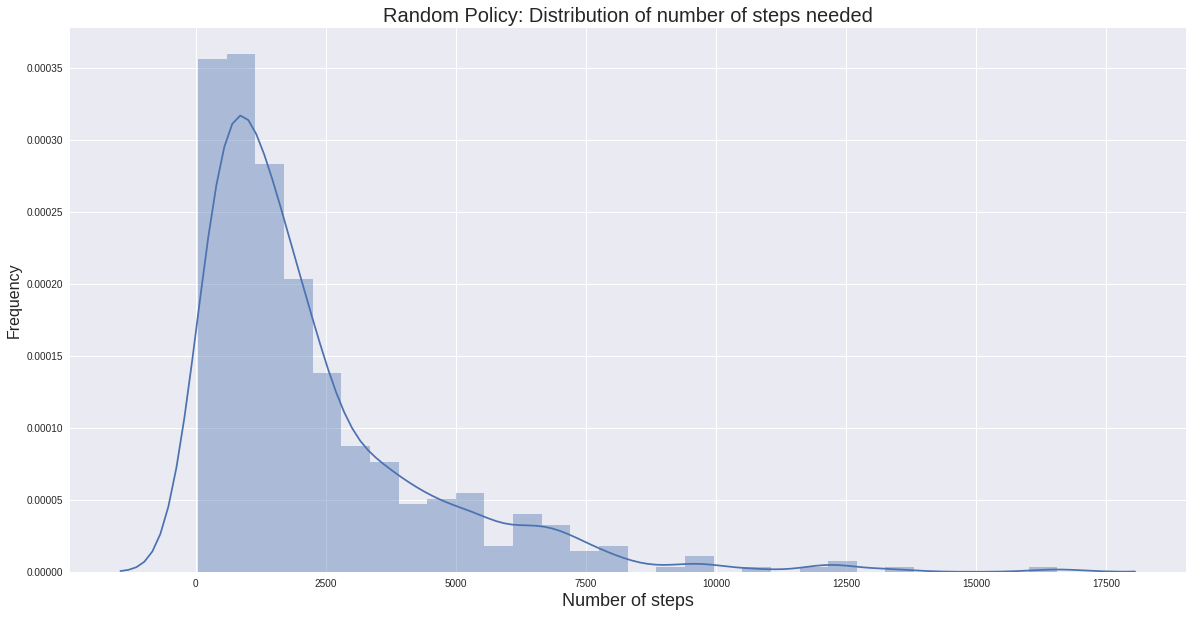

In [11]:
plt.figure(figsize=(20,10))
counts = [random_policy_steps_count() for i in range(500)]
sns.distplot(counts)
plt.title("Random Policy: Distribution of number of steps needed", fontsize=20)
plt.xlabel('Number of steps', fontsize=18)
plt.ylabel('Frequency', fontsize=16)

In [12]:
print("An agent using Random search takes about an average of " + str(int(np.mean(counts)))
      + " steps to successfully complete its mission.")

An agent using Random search takes about an average of 2247 steps to successfully complete its mission.


In [13]:
def policy_eval(policy, env, discount_factor=1.0, theta=0.00001):
    """
    Evaluate a policy given an environment and a full description of the environment's dynamics.
    
    Args:
        policy: [S, A] shaped matrix representing the policy.
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
    
    Returns:
        Vector of length env.nS representing the value function.
    """
    # Start with a random (all 0) value function
    V = np.zeros(env.env.nS)
    while True:
        # TODO: Implement!
        delta = 0  #delta = change in value of state from one iteration to next
       
        for state in range(env.env.nS):  #for all states
            val = 0  #initiate value as 0
            
            for action,act_prob in enumerate(policy[state]): #for all actions/action probabilities
                for prob,next_state,reward,done in env.env.P[state][action]:  #transition probabilities,state,rewards of each action
                    val += act_prob * prob * (reward + discount_factor * V[next_state])  #eqn to calculate
            delta = max(delta, np.abs(val-V[state]))
            V[state] = val
        if delta < theta:  #break if the change in value is less than the threshold (theta)
            break
    return np.array(V)

def policy_iteration(env, policy_eval_fn=policy_eval, discount_factor=1.0):
    """
    Policy Improvement Algorithm. Iteratively evaluates and improves a policy
    until an optimal policy is found.
    
    Args:
        env: The OpenAI envrionment.
        policy_eval_fn: Policy Evaluation function that takes 3 arguments:
            policy, env, discount_factor.
        discount_factor: gamma discount factor.
        
    Returns:
        A tuple (policy, V). 
        policy is the optimal policy, a matrix of shape [S, A] where each state s
        contains a valid probability distribution over actions.
        V is the value function for the optimal policy.
        
    """
    def one_step_lookahead(state, V):
        """
        Helper function to calculate the value for all action in a given state.
        
        Args:
            state: The state to consider (int)
            V: The value to use as an estimator, Vector of length env.nS
        
        Returns:
            A vector of length env.nA containing the expected value of each action.
        """
        A = np.zeros(env.env.nA)
        for a in range(env.env.nA):
            for prob, next_state, reward, done in env.env.P[state][a]:
                A[a] += prob * (reward + discount_factor * V[next_state])
        return A
    # Start with a random policy
    policy = np.ones([env.env.nS, env.env.nA]) / env.env.nA

    while True:
        # Implement this!
        curr_pol_val = policy_eval_fn(policy, env, discount_factor)  #eval current policy
        policy_stable = True  #Check if policy did improve (Set it as True first)
        for state in range(env.env.nS):  #for each states
            chosen_act = np.argmax(policy[state])  #best action (Highest prob) under current policy
            act_values = one_step_lookahead(state,curr_pol_val)  #use one step lookahead to find action values
            best_act = np.argmax(act_values) #find best action
            if chosen_act != best_act:
                policy_stable = False  #Greedily find best action
            policy[state] = np.eye(env.env.nA)[best_act]  #update 
        if policy_stable:
            return policy, curr_pol_val
    
    return policy, np.zeros(env.env.nS)

def value_iteration(env, theta=0.0001, discount_factor=1.0):
    """
    Value Iteration Algorithm.
    
    Args:
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
        
    Returns:
        A tuple (policy, V) of the optimal policy and the optimal value function.        
    """
    
    def one_step_lookahead(state, V):
        """
        Helper function to calculate the value for all action in a given state.
        
        Args:
            state: The state to consider (int)
            V: The value to use as an estimator, Vector of length env.nS
        
        Returns:
            A vector of length env.nA containing the expected value of each action.
        """
        A = np.zeros(env.env.nA)
        for act in range(env.env.nA):
            for prob, next_state, reward, done in env.env.P[state][act]:
                A[act] += prob * (reward + discount_factor*V[next_state])
        return A
    
    V = np.zeros(env.env.nS)
    while True:
        delta = 0  #checker for improvements across states
        for state in range(env.env.nS):
            act_values = one_step_lookahead(state,V)  #lookahead one step
            best_act_value = np.max(act_values) #get best action value
            delta = max(delta,np.abs(best_act_value - V[state]))  #find max delta across all states
            V[state] = best_act_value  #update value to best action value
        if delta < theta:  #if max improvement less than threshold
            break
    policy = np.zeros([env.env.nS, env.env.nA])
    for state in range(env.env.nS):  #for all states, create deterministic policy
        act_val = one_step_lookahead(state,V)
        best_action = np.argmax(act_val)
        policy[state][best_action] = 1
        
    
    # Implement!
    return policy, V

In [14]:
env = gym.make('Taxi-v2')
random_policy = np.ones([env.env.nS, env.env.nA]) / env.env.nA
policy_eval(random_policy,env,discount_factor=0.95)

array([-66.98313734, -72.0552561 , -71.82275936, -72.13589542,
       -79.64708927, -79.4270611 , -79.65147432, -79.63871504,
       -79.07254608, -79.10269345, -78.3875735 , -79.10505531,
       -79.81671409, -79.81060032, -79.81765665, -79.6925471 ,
       -59.75288888, -71.33388311, -70.80303096, -71.5180041 ,
       -72.64022323, -75.50799664, -75.3765432 , -75.55359007,
       -79.57926106, -79.3169249 , -79.58448929, -79.56927654,
       -79.23018522, -79.2552079 , -78.66164932, -79.25716827,
       -79.78723155, -79.78013338, -79.78832586, -79.64307314,
       -68.04939921, -74.24901585, -73.94171338, -74.52901578,
       -78.9466788 , -79.3570737 , -79.33826214, -79.36359837,
       -77.88594922, -76.56749029, -77.91222545, -77.83576752,
       -79.71837887, -79.72753061, -79.51044202, -79.7282476 ,
       -79.47489602, -79.45737113, -79.47759776, -79.11898469,
       -75.91030083, -73.61446202, -76.47955166, -76.11404129,
       -79.24493677, -79.5391139 , -79.52562956, -79.54

In [15]:
pol_iter_policy = policy_iteration(env,policy_eval,discount_factor=0.99)
pol_iter_policy[0]

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.]])